# Detectron for Label Checking

We classify whether labels are _good_ or _bad_, in order to be used both before the merging step and after the merging step.

1. Before: Detect bad labels out of the four _transformed_ labels and exclude them from merging.
1. After: If a final merged label is classified as _bad_, we don't show it in the final output.

We train a detectron model (as we did for the label segmentation) on a mix of _good_ and _bad_ images from before merging and after merging. Our training dataset consists of 365 images and our validation set has 122 images. 

Note that our dataset consists of bounding boxes on each image, slightly smaller than the image size (5 pixel border).

### Step 1 -- Set up

#### Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Installs

In [2]:
!python -m pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp310-cp310-linux_x86_64.whl size=44091 sha256=8e1257b08e5cbb4e5cb5c119eaabe92cf3c532b472bc5f570d3c99b626684dd8
  Stored in directory: /root/.cache/pip/wheels/70/83/31/975b737609aba39a4099d471d5684141c1fdc3404f97e7f68a
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0.1
    Uninstalling PyYAML-6.0.1:
      Successfully uninstalled PyYAML-6.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.12.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
flax 0.7.0 requires PyYAML>=5.4.1, but you have pyyaml 5.1 which is incompatible.
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-me08p22

#### Standard Library Imports

In [3]:
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow
import glob
import torch
import pandas as pd
import os
import random

#### Detectron Imports

In [4]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.visualizer import ColorMode

### Step 2 -- Register Instances

We provide a training, validation, and test set.

In [5]:
register_coco_instances("my_dataset_train", {}, "/content/drive/My Drive/ALICE/bad_label_detection/masks/detection_train.json", "/content/drive/My Drive/ALICE/bad_label_detection/images/train")
register_coco_instances("my_dataset_val", {}, "/content/drive/My Drive/ALICE/bad_label_detection/masks/detection_val.json", "/content/drive/My Drive/ALICE/bad_label_detection/images/val")
register_coco_instances("my_dataset_test", {}, "/content/drive/My Drive/ALICE/bad_label_detection/masks/detection_test.json", "/content/drive/My Drive/ALICE/bad_label_detection/images/test")

### Step 3 -- View Examples

[07/27 13:14:16 d2.data.datasets.coco]: Loading /content/drive/My Drive/ALICE/bad_label_detection/masks/detection_train.json takes 1.19 seconds.
WARNING [07/27 13:14:16 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/27 13:14:16 d2.data.datasets.coco]: Loaded 365 images in COCO format from /content/drive/My Drive/ALICE/bad_label_detection/masks/detection_train.json


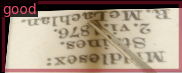

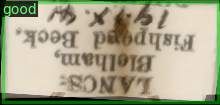

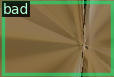

In [8]:
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")



for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

### Step 4 -- Training Setup

In [21]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1000 #adjust up if val mAP is still rising, adjust down if overfit
#cfg.SOLVER.STEPS = (1000, 1500)
#cfg.SOLVER.GAMMA = 0.05
cfg.SOLVER.STEPS = []        # do not decay learning rate


cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

cfg.TEST.EVAL_PERIOD = 300

In [22]:
class CocoTrainer(DefaultTrainer):

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):

        if output_folder is None:
            os.makedirs("coco_eval", exist_ok=True)
            output_folder = "coco_eval"

        return COCOEvaluator(dataset_name, cfg, False, output_folder)

### Step 5 -- Train

In [24]:
os.makedirs(cfg.OUTPUT_DIR,exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/27 14:09:54 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:01, 239MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[07/27 14:09:57 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[07/27 14:10:36 d2.utils.events]:  eta: 0:28:38  iter: 19  total_loss: 1.741  loss_cls: 1.137  loss_box_reg: 0.5857  loss_rpn_cls: 0.002141  loss_rpn_loc: 0.03624    time: 1.7384  last_time: 1.9527  data_time: 0.0393  last_data_time: 0.0071   lr: 1.9981e-05  max_mem: 6315M
[07/27 14:11:16 d2.utils.events]:  eta: 0:29:10  iter: 39  total_loss: 1.353  loss_cls: 0.7011  loss_box_reg: 0.5592  loss_rpn_cls: 0.002631  loss_rpn_loc: 0.0441    time: 1.7875  last_time: 1.8921  data_time: 0.0065  last_data_time: 0.0051   lr: 3.9961e-05  max_mem: 6318M
[07/27 14:11:52 d2.utils.events]:  eta: 0:28:22  iter: 59  total_loss: 0.9771  loss_cls: 0.373  loss_box_reg: 0.5283  loss_rpn_cls: 0.00238  loss_rpn_loc: 0.0405    time: 1.7907  last_time: 1.6743  data_time: 0.0073  last_data_time: 0.0101   lr: 5.9941e-05  max_mem: 6318M
[07/27 14:12:26 d2.utils.events]:  eta: 0:27:37  iter: 79  total_loss: 0.8791  loss_cls: 0.2907  loss_box_reg: 0.5316  loss_rpn_cls: 0.001129  loss_rpn_loc: 0.02809    time: 1.772

### Step 6 -- Evaluation

Evaluate with test dataset.

#### Predictor

In [25]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

[07/27 15:06:29 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
WARNING [07/27 15:06:30 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [07/27 15:06:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/27 15:06:31 d2.data.datasets.coco]: Loaded 58 images in COCO format from /content/drive/My Drive/ALICE/bad_label_detection/masks/detection_test.json
[07/27 15:06:31 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|    bad     | 36           |    good    | 22           |
|            |              |            |              |
|   total    | 58           |            |              |
[07/27 15:06:31 d2.data.dataset_mapper]: [Datase

OrderedDict([('bbox',
              {'AP': 7.855218844444238,
               'AP50': 30.85063257456967,
               'AP75': 2.5825082508250827,
               'APs': nan,
               'APm': 7.7227722772277225,
               'APl': 7.931561643559312,
               'AP-bad': 1.9585410706552235,
               'AP-good': 13.751896618233253})])

#### With Visualizer (Optional)

[07/27 15:08:35 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


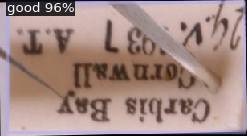

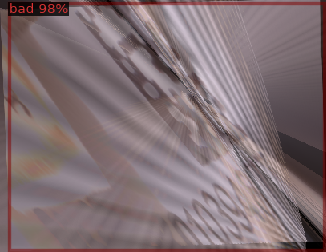

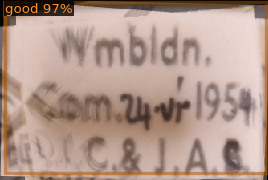

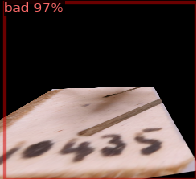

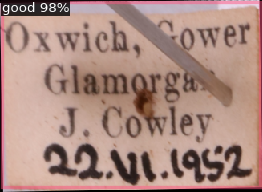

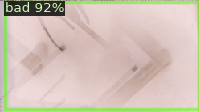

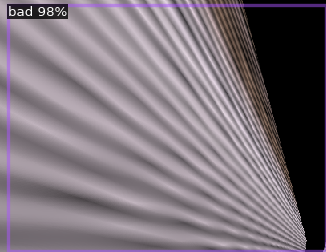

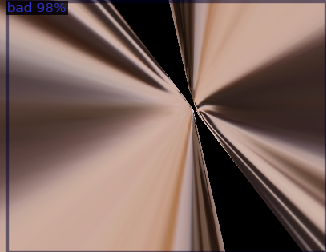

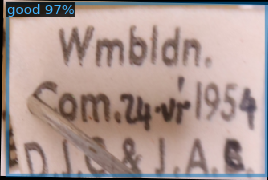

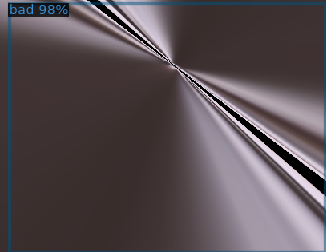

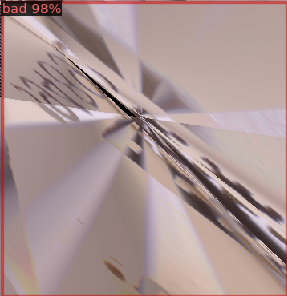

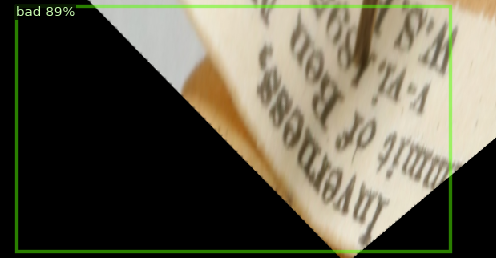

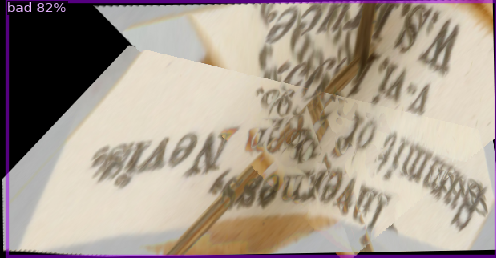

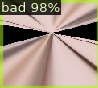

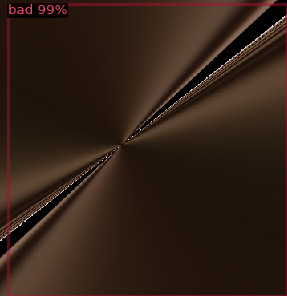

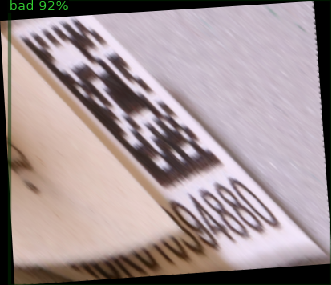

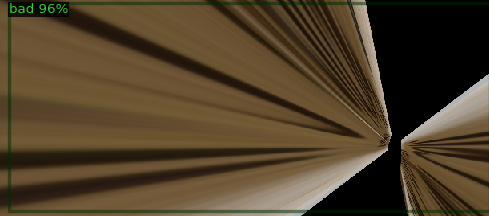

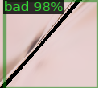

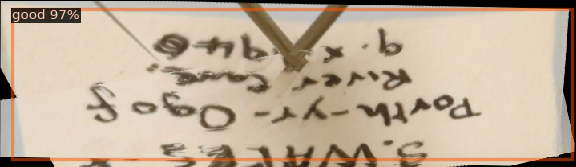

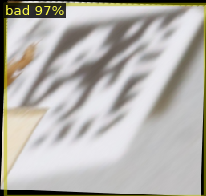

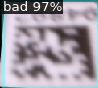

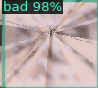

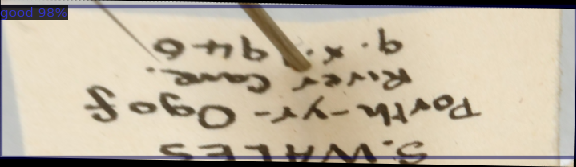

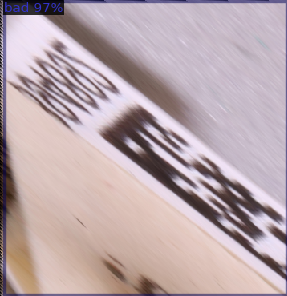

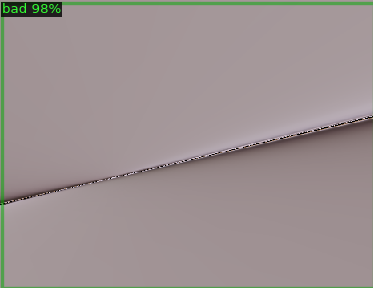

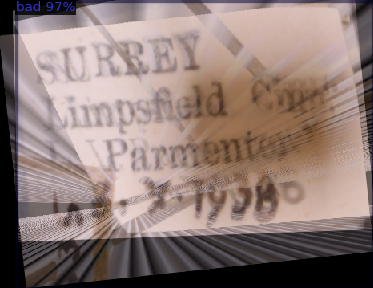

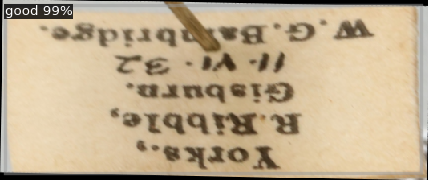

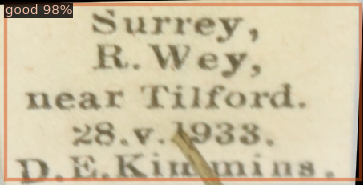

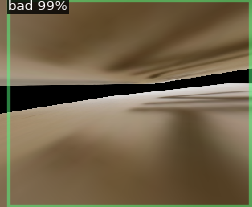

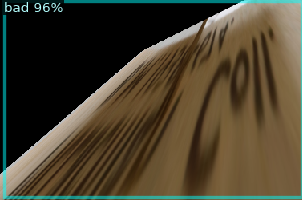

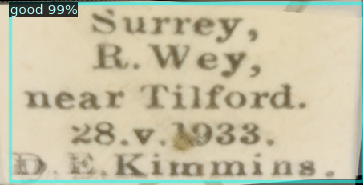

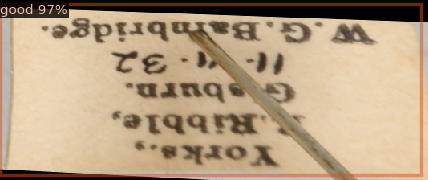

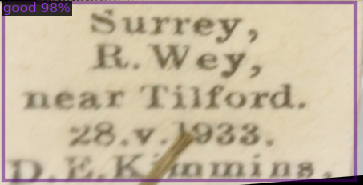

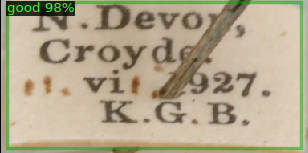

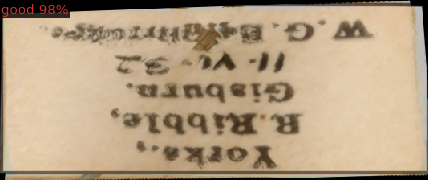

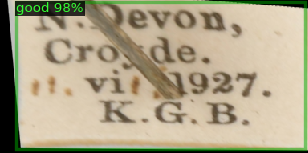

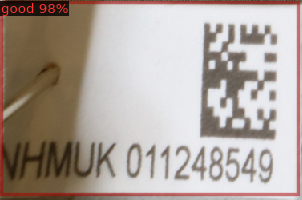

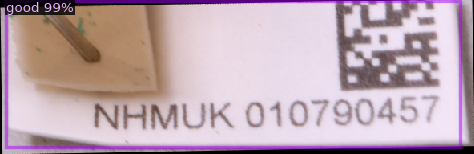

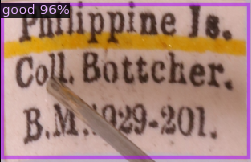

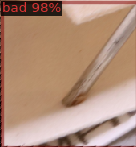

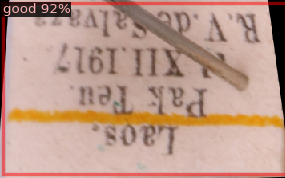

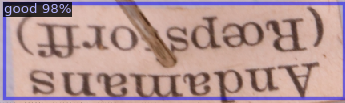

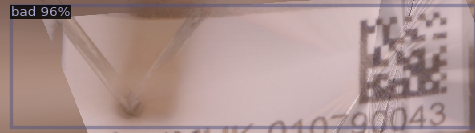

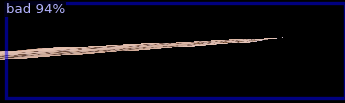

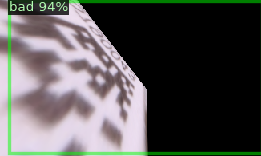

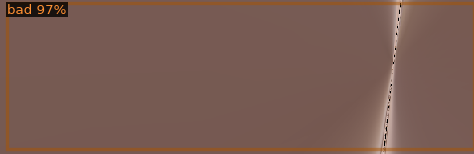

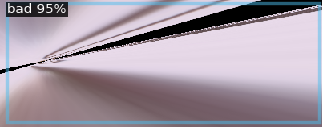

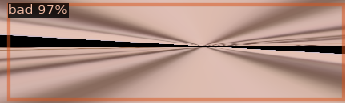

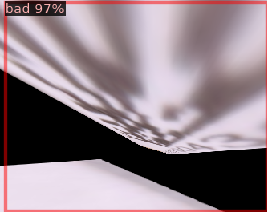

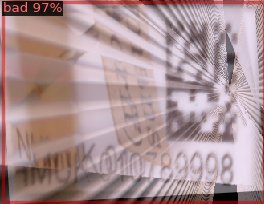

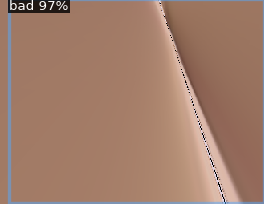

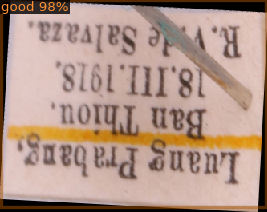

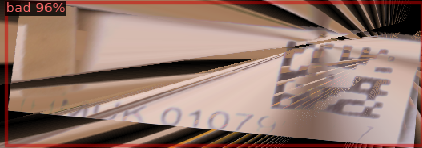

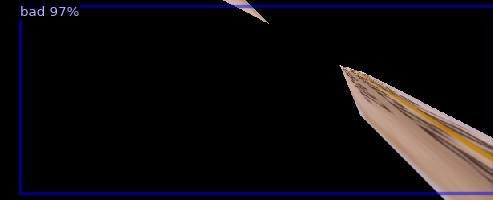

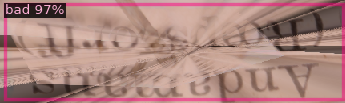

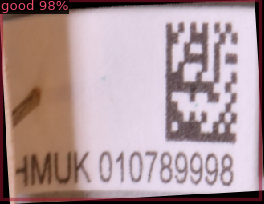

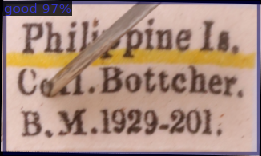

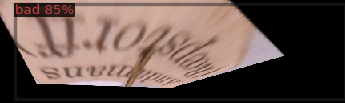

In [27]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")



for imageName in glob.glob("/content/drive/My Drive/ALICE/bad_label_detection/images/test/*.png"):
    im = cv2.imread(imageName)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata,
                scale=0.8
                 )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

#### Without Visualizer
(i.e. save results into dataframe / csv).

In [66]:
predictions = []
for i,imageName in enumerate(glob.glob("/content/test_images/*.png")):
    im = cv2.imread(imageName)
    outputs = predictor(im)
    name = imageName[21:]
    p = outputs['instances']
    predictions.append([name,p.pred_classes[0].item()])


pd.DataFrame(predictions).to_csv('bad_label_detection_results.csv',index=False)

### Step 7 -- Save Model

In [72]:
model_ = torch.load('/content/output/model_final.pth')

In [73]:
torch.save(model_, '/content/drive/My Drive/ALICE/bad_label_detection/model.pth')